In [1]:
import numpy
# составляющей.специальный для сигмоидной функции expit()
import scipy.special
#import scipy.ndimage
# библиотека для построения массивов
import matplotlib.pyplot
# убедитесь, что участки находятся внутри этой записной книжки, а не внешнего окна
%matplotlib inline
#plt.show() # Вместо %matplotlib inline в других средах, не notebook
#import scipy.misc
# glob помогает выбрать несколько файлов, используя шаблоны
#import glob
from time import time, sleep #Для замера времени выполнения функций
from tqdm import tqdm #Для вывода прогресса вычисления функций
from tqdm import tqdm_notebook #Для вывода прогресса вычисления функций. Только для python notebook
import sys
# glob помогает выбрать несколько файлов, используя шаблоны
import glob
# помощник для загрузки данных из файлов изображений PNG
import scipy.misc
import re # Для извлечения дробной и целой части

In [2]:

# Определение класса нейронной сети
class neuralNetwork:
    
    
    # инициализация нейронной сети
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate, hiddennodes2): #констр.(входной слой, скрытый слой, выходной слой)
        # задать количество узлов во всех входных, скрытых, выходных слоях
        self.inodes = inputnodes # входной слой
        self.hnodes = hiddennodes # скрытый слой
        self.hnodes2 = hiddennodes2 # скрытый слой после пулинга
        self.onodes = outputnodes # выходной слой
        
        self.m = 28 #Размер входного массива(ДхШ)
        self.k = 5 #Размер весов (ДхШ)
        self.m_k_1 = (self.m-self.k)+1
        self.m_k = self.m-self.k
        self.stok_w = 9 #Число ядер свертки (весов)
        self.stob_w = self.k*self.k #Количество элементов 1го ядра свертки
        self.m_k_stw = self.stok_w*self.m_k_1*self.m_k_1 #Общее кол-во элементов выходного слоя = hiddennodes = self.hnodes
        self.hidden_inputs = numpy.zeros((self.stok_w, self.m_k_1, self.m_k_1)) #Выходной массив
        
        # Пулиинг данные
        self.pool_m = 2 # Матрица ядра пуллинга
        self.m_k_1_pool = int(self.m_k_1/self.pool_m) # Размерность слоя пуллинга
        #m_k_1_pool = int(m_k_1_pool) # Размерность слоя пуллинга
        self.hidden_outputs_mp = numpy.zeros((self.stok_w, self.m_k_1_pool, self.m_k_1_pool)) # Матрица выходного массива пулинга
        self.hidden_outputs_el = numpy.zeros((self.stok_w, self.m_k_1_pool, self.m_k_1_pool), dtype='<U32') # хранит адрес макс элемента
        
        #Для вывода карт свойст скрытого слоя  
        self.hidden_outputs_image = numpy.zeros((self.stok_w, self.m_k_1, self.m_k_1))
                                                    # МАТРИЦЫ ВЕСОВ
        self.wih = numpy.random.normal(0.0, pow(self.stob_w, -0.5), (self.stok_w, self.k, self.k))
        #w_rot180_w1 = rot_180(self.wih, self.stok_w)#Переворачиваем матрицу
        #print(self.wih)
        
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes2, self.hnodes))
        self.who2 = numpy.random.normal(0.0, pow(self.hnodes2, -0.5), (self.onodes, self.hnodes2)) # После пуллинг слоя
        # Спокойно можно задать веса как случайное от -0,5 до 0,5
        #self.wih2 = (numpy.random.rand(self.hnodes, self.inodes) -0.5) 
        #self.who2 = (numpy.random.rand(self.onodes, self.hnodes) -0.5)

        # скорость обучения
        self.lr = learningrate
        
        # функция активации-функция сигмоида
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        
        pass

    
    # обучение нейронной сети
    def train(self, inputs_list, targets_list): # принемает входной список данных,targets ответы
        # Преобразовать список входов в 2D массив
        #inputs = numpy.array(inputs_list, ndmin=2).T # матрица числа
        inputs = numpy.array(inputs_list.reshape(self.m , self.m)) # матрица числа

        targets = numpy.array(targets_list, ndmin=2).T # матрица ответов какое это число
        
        
                                        # ВЫЧИСЛЕНИЕ СИГНАЛОВ ПО СЛОЯМ
        # вычислить сигналы в скрытом слое (матрица сигналов скрытого слоя)
        #hidden_inputs = numpy.dot(self.wih, inputs) # сигнал скр.слоя = вес вх слоя * значение входа, Xhidden = Winput_hidden * I
        for s in range(self.stok_w):
            for h in range(self.m_k_1):
                for w in range(self.m_k_1):
                    self.hidden_inputs[s,h,w] = numpy.sum(inputs[h:h+self.k, w:w+self.k] * self.wih[s])
        
        # вычислить сигналы, возникающие из скрытого слоя. сигмоида(Xhidden - сигнал скр.слоя)
        hidden_outputs = self.activation_function(self.hidden_inputs) #Сигмоида
        #hidden_outputs = numpy.maximum(self.hidden_inputs, 0.001) # RELU
        
        # Макспуллинг
        for s in range(self.stok_w):
            for h in range(self.m_k_1_pool):
                for w in range(self.m_k_1_pool):
                    temp2 = hidden_outputs[s, h*self.pool_m:h*self.pool_m+self.pool_m, w*self.pool_m:w*self.pool_m+self.pool_m] # Для хранения подматрицы с нулевыми и макс знач.
                    self.hidden_outputs_mp[s,h,w] = hidden_outputs[s, h*self.pool_m:h*self.pool_m+self.pool_m, w*self.pool_m:w*self.pool_m+self.pool_m].max() # Матрица выходного массива после пулинга
                    for i in range(self.pool_m):
                        for j in range(self.pool_m):
                            if temp2[i, j] == self.hidden_outputs_mp[s,h,w]:
                                temp3 = str(i+h*self.pool_m) + ',' + str(j+w*self.pool_m)
                        
                    self.hidden_outputs_el[s, h, w] = temp3
        
        
        # вычислить сигналы в окончательный выходной слой (матрица сигналов выходного слоя)
        final_inputs = numpy.dot(self.who2, numpy.array(self.hidden_outputs_mp.flatten(), ndmin=2).T) # сигнал вых.слоя = вес скр. слоя * значение сигнала скр.слоя
        # вычислить сигналы, исходящие из конечного выходного слоя. сигмоида(Xoutputs - сигнал вых.слоя)
        final_outputs = self.activation_function(final_inputs) # Сигмоида
        #final_outputs = numpy.maximum(final_inputs, 0) # RELU
        #final_outputs = numpy.exp(final_inputs)/numpy.sum(numpy.exp(final_inputs), axis=0) # Софтмакс
        #final_outputs = final_inputs # Без функции активации
        
                                            # ВЫЧИСЛЕНИЕ ОШИБКИ ПО СЛОЯМ
        #  ошибка выходного слоя является (цель - фактическое) 
        output_errors = -(targets - final_outputs)
        #output_errors = (final_outputs - targets) # Только для софтмакс
        # Скрытая ошибка слоя макспулинга
        hidden_errors_mp = numpy.dot(self.who2.T, output_errors)
        hidden_errors_mp = self.hidden_outputs_mp.reshape(self.stok_w, self.m_k_1_pool, self.m_k_1_pool)
        
        # Обнулим ошибки перед пулингом
        hidden_errors = numpy.zeros((self.stok_w, self.m_k_1, self.m_k_1))
        for s in range(self.stok_w):
            for h in range(self.m_k_1_pool):
                for w in range(self.m_k_1_pool):
                    result = re.split(r'[,]', self.hidden_outputs_el[s,h,w]) # Разбивает строку по разделителю ',' можно сраху несколько разделителей 
                    i = int(result[0])
                    j = int(result[1])
                    hidden_errors[s,i,j] = hidden_errors_mp[s,h,w]
        
                
        #hidden_errors = numpy.array(hidden_errors.flatten().transpose(self.stok_w, self.m_k_1, self.m_k_1))
        
                                            # ОБНОВЛЕНИЕ ВЕСОВ ПО СЛОЯМ
        # обновления весов связей между скрытым пуллинг слоем и выходным слоями
        #self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        self.who2 -= self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(numpy.array(self.hidden_outputs_mp.flatten(), ndmin=2).T)) # Сигмоида        
        #self.who += -self.lr * numpy.dot((output_errors), numpy.transpose(numpy.array(hidden_outputs.flatten(), ndmin=2).T)) # Софтмакс
        #self.who += -self.lr * numpy.dot((output_errors * (final_outputs > 0)*(final_outputs == 0)), numpy.transpose(numpy.array(hidden_outputs.flatten(), ndmin=2).T))# RELU
        
        # обновления весов связей между скрытым слоем и пуллинг слоем
        #self.who += self.lr * numpy.dot(numpy.array(hidden_errors.flatten(), ndmin=2).T * numpy.array(hidden_outputs.flatten(), ndmin=2).T 
                                        #* (1.0 - numpy.array(hidden_outputs.flatten(), ndmin=2).T), numpy.transpose(numpy.array(hidden_outputs.flatten(), ndmin=2).T))
        
        # обновления весов связей между входным и скрытым слоями             
        for s in range(self.stok_w):
            for h in range(self.m-(self.m_k_1)+1):
                for w in range(self.m-(self.m_k_1)+1):
                    #w1[s, h, w] = np.sum(e2[s] * x1[h:h+m_k_1, w:w+m_k_1])
                    inputs_t = inputs[h:h+self.m_k_1, w:w+self.m_k_1]
                    inputs_t = numpy.fliplr(inputs_t)
                    inputs_t = numpy.flipud(inputs_t)
                    #self.wih[s, h, w] +=  numpy.sum(hidden_errors[s] * inputs_t * self.lr)
                    self.wih[s, h, w] -= numpy.sum(hidden_errors[s] * inputs_t * self.lr) #Для софтмакс и без функции активации и RRELU на выходе
                    
        #Запоминаем карту свойст скрытого слоя для просмотра            
        self.hidden_outputs_image = hidden_outputs 
        pass

                                        # МЕТОД ПРОГОНА СВОИХ ЗНАЧЕНИЙ ПО СЕТИ
    # запросить нейронную сеть
    def query(self, inputs_list): # Функция прогонки по слоям своих данных. Принемает свой набор тестовых данных
        # Преобразовать список входов в 2D массив
        #inputs = numpy.array(inputs_list, ndmin=2).T
        inputs = numpy.array(inputs_list.reshape(self.m , self.m)) # матрица числа
        
        # вычислить сигналы в скрытом слое (матрица сигналов скрытого слоя)
        #hidden_inputs = numpy.dot(self.wih, inputs) # сигнал скр.слоя = вес вх слоя * значение входа, Xhidden = Winput_hidden * I
        for s in range(self.stok_w):
            for h in range(self.m_k_1):
                for w in range(self.m_k_1):
                    self.hidden_inputs[s,h,w] = numpy.sum(inputs[h:h+self.k, w:w+self.k] * self.wih[s])
        
        # вычислить сигналы, возникающие из скрытого слоя. сигмоида(Xhidden - сигнал скр.слоя)
        hidden_outputs = self.activation_function(self.hidden_inputs) #Сигмоида
        #hidden_outputs = numpy.maximum(self.hidden_inputs, 0.001) # RELU
        
        # Макспуллинг
        for s in range(self.stok_w):
            for h in range(self.m_k_1_pool):
                for w in range(self.m_k_1_pool):
                    temp2 = hidden_outputs[s, h*self.pool_m:h*self.pool_m+self.pool_m, w*self.pool_m:w*self.pool_m+self.pool_m] # Для хранения подматрицы с нулевыми и макс знач.
                    self.hidden_outputs_mp[s,h,w] = hidden_outputs[s, h*self.pool_m:h*self.pool_m+self.pool_m, w*self.pool_m:w*self.pool_m+self.pool_m].max() # Матрица выходного массива после пулинга
        
        
        # вычислить сигналы в окончательный выходной слой (матрица сигналов выходного слоя)
        final_inputs = numpy.dot(self.who2, numpy.array(self.hidden_outputs_mp.flatten(), ndmin=2).T) # сигнал вых.слоя = вес скр. слоя * значение сигнала скр.слоя
        # вычислить сигналы, исходящие из конечного выходного слоя. сигмоида(Xoutputs - сигнал вых.слоя)
        final_outputs = self.activation_function(final_inputs) # Сигмоида
        #final_outputs = numpy.maximum(final_inputs, 0) # RELU
        #final_outputs = numpy.exp(final_inputs)/numpy.sum(numpy.exp(final_inputs), axis=0) # Софтмакс
        #final_outputs = final_inputs # Без функции активации
        
        
        return final_outputs
    
    
                                # МЕТОД ОБРАТНОЙ ПОДАЧИ СИГНАЛА НА ВЫХОД НЕЙРОНОЙ СЕТИ
    # backquery обратный запрос нейронной сети мы будем использовать ту же терминологию для каждого элемента, 
    # например цели являются значения справа от сети, хотя используется в качестве входного например 
    # hidden_output сигнал справа от средних узлов
    def backquery(self, targets_list): # аргумент принемает сигнал ответов выхода 
        # перенесите список целей в вертикальный массив
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # вычислить сигнал в конечном выходном слое
        # обратная функция сигмоиды x = ln [y/(1-y)] 
        final_inputs = self.inverse_activation_function(final_outputs) 

        # вычислить выходной сигнал скрытого слоя
        hidden_outputs = numpy.dot(self.who.T, final_inputs)

        # масштабировать их обратно до 0,01 до 0,99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # вычислить сигнал в скрытом слое
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # вычислить сигнал из входного слоя
        inputs = numpy.dot(self.wih.T, hidden_inputs)

        # масштабировать их обратно до 0,01 до 0,99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs
    
    # Просмотр карты свойсв
    def bd(self, i):
        return self.hidden_outputs_image[i]
    
    def bdmaxpool(self, i):
        return self.hidden_outputs_mp[i]
        
        

In [3]:
# количество входных, скрытых и выходных узлов
input_nodes = 784
hidden_nodes = 5184
hidden_nodes2 = 1296 # 24/2 * 24/2 * 9 
output_nodes = 10

# скорость обучения
learning_rate = 0.05

# создать экземпляр нейронной сети
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate, hidden_nodes2)

In [4]:
# загрузить mnist подготовки данных в формате CSV файла в список
training_data_file = open("mnist_dataset/mnist_train_100.csv", 'r') # 'r' - файл для чтения, а не для записи.
training_data_list = training_data_file.readlines() # readlines() - читает все строки в файле в переменную training_data_list
training_data_file.close() # закрываем фаел csv

In [5]:
# обучение нейронной сети

# эпох, сколько раз обучающий набор данных используется для обучения
epochs = 10

start = time()
for e in range(epochs):
    # Пройдите все записи в наборе тренировочных данных    
    #for record in training_data_list:
    for record in tqdm(training_data_list, desc = str(e+1)): # tqdm - используем интерактив состояния прогресса вычисления
    #for record in tqdm_notebook(training_data_list, desc = str(e+1)): # tqdm_notebook - как tqdm только доступна в notebook
        # разделите запись запятыми ','
        all_values = record.split(',') # split(',') - раздел строку на символы где запятая "," символ разделения
        # масштабирование и сдвиг входных данных
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01 #массив данных входа с масштабированием от 0,01 до 0,99        
        # создать целевые выходные значения (все 0.01, кроме нужной метки, которая равна 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        
        # all_values[0] - целевая метка для этой записи
        targets[int(all_values[0])] = 0.99 # перевод символов в int, 0 эл. ответ входа
        n.train(inputs, targets) # наш метод train - обучение нейронной сети
        pass
    pass
time_out = time() - start
print("Время выполнения: ", time_out, " сек" )

10: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.38it/s]


Время выполнения:  39.49526071548462  сек


In [6]:
# Загрузить CSV-файл данных теста mnist в список
test_data_file = open("mnist_dataset/mnist_test_10.csv", 'r') # 'r' - файл для чтения, а не для записи.
test_data_list = test_data_file.readlines()  # readlines() - читает все строки в файле в переменную test_data_list
test_data_file.close() # закрываем фаел csv

In [7]:
# проверить нейронную сеть

# Карта показателей эффективности сети, изначально пустая
scorecard = []

# Пройдите все записи в наборе тестовых данных
for record in tqdm(test_data_list):
    # разделите запись запятыми ',' 
    all_values = record.split(',') # split(',') - раздел строку на символы где запятая "," символ разделения
    # правильный ответ-первое значение
    correct_label = int(all_values[0])
    # масштабирование и сдвиг входных данных
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01 #массив данных входа с масштабированием от 0,01 до 0,99

    # запросить сеть
    outputs = n.query(inputs) # прогон по сети тестового значения из нашего файла. Наш метод query 
    # индекс самого высокого значения соответствует метке
    label = numpy.argmax(outputs)
    
    # добавить правильный или неправильный список
    if (label == correct_label): # если макс знач на выходе label = ответу (0 индекс из массива) correct_label
        # Ответ сети соответствует правильный ответ, добавить 1 в систему показателей
        scorecard.append(1)
    else:
        # Ответ сети не соответствует правильному ответу, добавьте 0 в систему показателей
        scorecard.append(0)
        pass
    
    pass

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.04it/s]


In [8]:
# вычислить оценку производительности, доля правильных ответов
scorecard_array = numpy.asarray(scorecard) # numpy.asarray - преобразование списка в массив 

print ("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.6


In [9]:
# наш собственный набор тестовых данных изображения
our_own_dataset = []

# загрузить данные изображения в формате PNG, как установить тестовые данные
for image_file_name in glob.glob('my_own_images/2828_my_own_?.png'): # проход по файлам изобр папке my_own_images
    #glob - из библиотеки glob, помогает выбрать несколько файлов, используя шаблоны
    
    # используйте имя правильно установить метки
    label = int(image_file_name[-5:-4]) # хранит число нарисованое в файле ?.png, -5 это число (?)
    # от -5 до -4 это будет ? т.е число
    
    # Загрузить данные изображения из png файлов в массив
    print ("loading ... ", image_file_name) # вывод пути и имени открытого файла
    
    img_array = scipy.misc.imread(image_file_name, flatten=True) #“flatten=True” (“выровнять=True) ”- превращает 
    #изображения в простой массив чисел с плавающей запятой
    
    # изменить формат из 28x28 в список 784 значений, инвертировать значения
    img_data  = 255.0 - img_array.reshape(784) #преобразует массив из квадрата 28x28 в длинный список значений
    # затем данные шкалы в диапазоне от 0,01 до 1,0 
    #вычитание значений массива из 255.0. т.к 0 обычно означает черное и 255 означает белое, но набор данных MNIST  
    #имеет обратный путь, поэтому мы должны обратить вспять значения
    
    # затем данные шкалы в диапазоне от 0,01 до 1,0
    img_data = (img_data / 255.0 ) # массив данных входа с масштабированием от 0,01 до 0,99
    print(numpy.min(img_data)) # вывод мин знач элемента в обработанном массиве данных
    print(numpy.max(img_data)) # вывод макс знач элемента в обработанном массиве данных
    
    # добавить метку и данные изображения к набору тестовых данных
    record = numpy.append(label,img_data)
    our_own_dataset.append(record) # массив для matplotlib,чтоб вывести изображенгие
    
    pass

In [10]:
# проверить нейронную сеть с нашими собственными изображениями

# запись для тестирования
item = 2

# изображение участка
matplotlib.pyplot.imshow(our_own_dataset[item][1:].reshape(28,28), cmap='Greys', interpolation='None')
# our_own_dataset- наш собственный набор тестовых данных

# правильный ответ-первое значение
correct_label = our_own_dataset[item][0] # 3й фаел из папки тестовых данных, 0 - ответ какое число

# data-оставшиеся значения
inputs = our_own_dataset[item][1:] # значение числа без ответа

# запросить сеть
outputs = n.query(inputs) # прогоняем тестовую выборку по сети
print (outputs) # вывод по выходу сети

# индекс самого высокого значения соответствует метке
label = numpy.argmax(outputs)
print("network says ", label)

# добавить правильный или неправильный список
if (label == correct_label): # если макс знач на выходе label = ответу (0 индекс из массива) correct_label
    print ("match!") # угадал
else:
    print ("no match!") # не угадал
    pass

IndexError: list index out of range

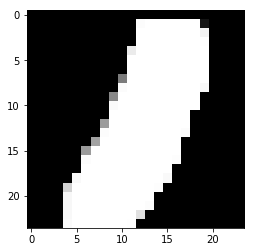

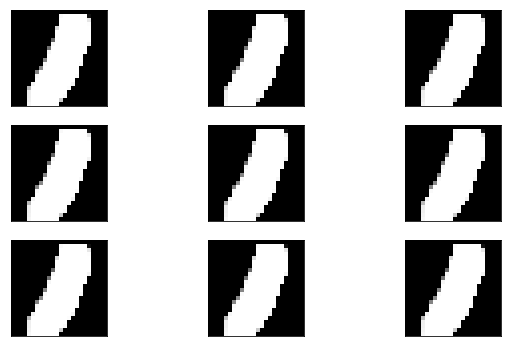

In [11]:
# Данные изображения в признаках(в сврточном слое hidden_jutput)
# получить данные изображения
image_o2 = n.bd(0)
# данные изображения участка
matplotlib.pyplot.imshow(image_o2, cmap='Greys', interpolation='None')

fig = matplotlib.pyplot.figure(figsize=(10,6))
for j in range(9):
    ax = fig.add_subplot(3, 3, j+1)
    ax.imshow(n.bd(j), 
              cmap=matplotlib.cm.binary, interpolation='none')
    matplotlib.pyplot.xticks(numpy.array([]))
    matplotlib.pyplot.yticks(numpy.array([]))
matplotlib.pyplot.show()

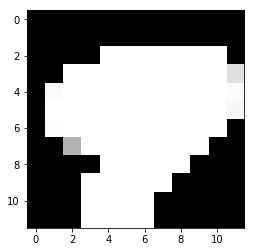

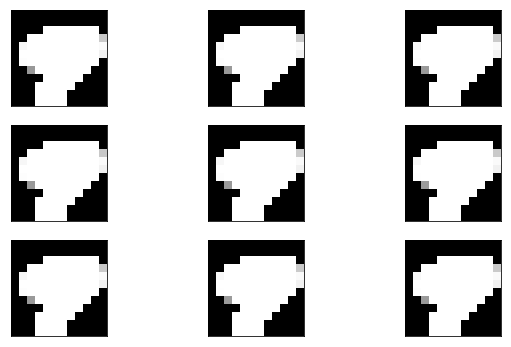

In [12]:
# Данные изображения в слое макспула
# получить данные изображения
image_o2 = n.bdmaxpool(0)
# данные изображения участка
matplotlib.pyplot.imshow(image_o2, cmap='Greys', interpolation='None')

fig = matplotlib.pyplot.figure(figsize=(10,6))
for j in range(9):
    ax = fig.add_subplot(3, 3, j+1)
    ax.imshow(n.bdmaxpool(j), 
              cmap=matplotlib.cm.binary, interpolation='none')
    matplotlib.pyplot.xticks(numpy.array([]))
    matplotlib.pyplot.yticks(numpy.array([]))
matplotlib.pyplot.show()

[ 0.99  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]


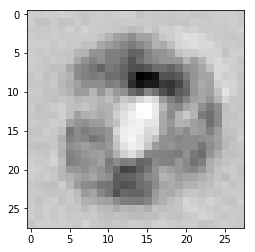

In [11]:
# запустить сеть назад, учитывая метку, посмотреть, какое изображение она производит

# label для тестирования
label = 0

# создать выходные сигналы для этой метки
targets = numpy.zeros(output_nodes) + 0.01 # нулевой массив + 0,01

# all_values[0] - целевая метка для этой записи
targets[label] = 0.99
print(targets)

# получить данные изображения
image_data = n.backquery(targets) # наш метод backquery прогонки назад. targets - входные данные подаваемые на выход сети

# данные изображения участка
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')